***Q1)In an additive hybrid model, the time series is first modelled using a linear model (Linear Regression, Huber Regression or Linear SVR). Then the linear model forecasts are subtracted from the time series data to obtain the residual series. The residual series is considered nonlinear and modelled using a nonlinear model (LSTM, or GRU). Then the final forecasts are obtained by adding the linear model forecasts with nonlinear model forecasts. Write a program using this additive hybrid model to forecast the number of passengers travelling in an airline. Use 70-15-15 % ratios in train, validation and test sets.***

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [17]:
import pandas as pd
data=pd.read_csv("Passengers.csv", parse_dates=['Month'])
data.head(5)

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [18]:
# Load the dataset
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')  # Convert to datetime
data.set_index('Month', inplace=True)

In [19]:
# Prepare the dataset
X = np.arange(len(data)).reshape(-1, 1)  # Time as feature (e.g., 0, 1, 2, ...)
y = data['#Passengers'].values

In [20]:
# Split into train, validation, and test sets (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)

In [46]:
# Linear Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_forecast = linear_model.predict(X_val)

In [48]:
# Residuals
residuals_val = y_val - linear_forecast

In [49]:
# Prepare residuals for LSTM
residuals_val = residuals_val.reshape((residuals_val.shape[0], 1, 1))

In [50]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
# Train LSTM on residuals
lstm_model.fit(residuals_val, y_val - linear_forecast, epochs=50, verbose=0)

In [52]:
# Forecast using LSTM
lstm_forecast = lstm_model.predict(residuals_val)

# Final forecast
final_forecast = linear_forecast + lstm_forecast.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


In [53]:
# Output the results
results = pd.DataFrame({
    'Actual': y_val,
    'Linear Forecast': linear_forecast,
    'LSTM Forecast': lstm_forecast.flatten(),
    'Final Forecast': final_forecast
}, index=pd.date_range(start=data.index[len(X_train)], periods=len(y_val), freq='M'))

print(results)

            Actual  Linear Forecast  LSTM Forecast  Final Forecast
1957-05-31     355       336.250909       6.594369      342.845278
1957-06-30     422       338.585383      32.178490      370.763872
1957-07-31     465       340.919856      48.220432      389.140288
1957-08-31     467       343.254329      48.089283      391.343612
1957-09-30     404       345.588803      22.296865      367.885668
1957-10-31     347       347.923276      -0.039110      347.884166
1957-11-30     305       350.257750      -4.397590      345.860160
1957-12-31     336       352.592223      -1.556685      351.035538
1958-01-31     340       354.926697      -1.370948      353.555749
1958-02-28     318       357.261170      -3.838011      353.423159
1958-03-31     362       359.595644       0.565499      360.161143
1958-04-30     348       361.930117      -1.259450      360.670667
1958-05-31     363       364.264590      -0.060017      364.204573
1958-06-30     435       366.599064      26.236452      392.83

<ipython-input-53-321d4b1f9ee2>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  }, index=pd.date_range(start=data.index[len(X_train)], periods=len(y_val), freq='M'))


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE, MSE, and RMSE for the final forecast
mae = mean_absolute_error(results['Actual'], results['Final Forecast'])
mse = mean_squared_error(results['Actual'], results['Final Forecast'])
rmse = np.sqrt(mse)

# Output the results
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 34.83
Mean Squared Error (MSE): 1863.36
Root Mean Squared Error (RMSE): 43.17


In [56]:
# Calculate MAPE
mape = np.mean(np.abs((results['Actual'] - results['Final Forecast']) / results['Actual'])) * 100

# Calculate accuracy percentage
accuracy_percentage = 100 - mape

# Output the results
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Accuracy Percentage: {accuracy_percentage:.2f}%')


Mean Absolute Percentage Error (MAPE): 8.80%
Accuracy Percentage: 91.20%


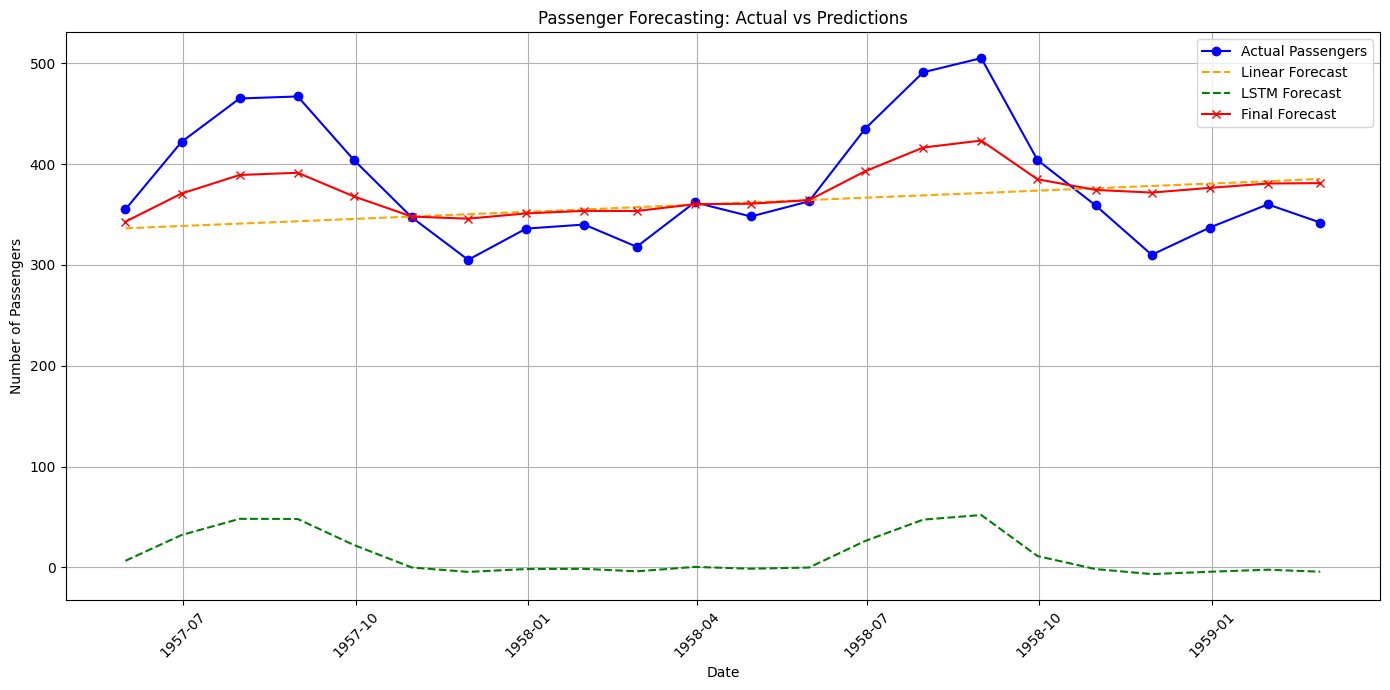

In [54]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Actual'], label='Actual Passengers', color='blue', marker='o')
plt.plot(results.index, results['Linear Forecast'], label='Linear Forecast', color='orange', linestyle='--')
plt.plot(results.index, results['LSTM Forecast'], label='LSTM Forecast', color='green', linestyle='--')
plt.plot(results.index, results['Final Forecast'], label='Final Forecast', color='red', marker='x')

# Adding labels and title
plt.title('Passenger Forecasting: Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show plot
plt.tight_layout()
plt.show()


***Q2) In a multiplicative hybrid model, the time series is first modelled using a linear model
(Linear Regression, Huber Regression or Linear SVR). Then the linear model forecasts
are divided from the time series data to obtain the residual series. The residual series is
considered nonlinear and modelled using a nonlinear model (LSTM, or GRU). Then
the final forecasts are obtained by multiplying the linear model forecasts with nonlinear
model forecasts. Write a program using this multiplicative hybrid model to forecast the
number of passengers travelling in an airline. Use 70-15-15 % ratios in train, validation
and test sets.***


In [43]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
data = pd.read_csv('Passengers.csv', parse_dates=['Month'])
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')  # Convert to datetime
data.set_index('Month', inplace=True)

# Prepare the dataset
X = np.arange(len(data)).reshape(-1, 1)  # Time as feature (e.g., 0, 1, 2, ...)
y = data['#Passengers'].values

# Split into train, validation, and test sets (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)

# Linear Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_forecast = linear_model.predict(X_val)

# Residuals
residuals_val = y_val / linear_forecast  # Using division for multiplicative model

# Prepare residuals for LSTM
residuals_val = residuals_val.reshape((residuals_val.shape[0], 1, 1))

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM on residuals
lstm_model.fit(residuals_val, y_val / linear_forecast, epochs=50, verbose=0)

# Forecast using LSTM
lstm_forecast = lstm_model.predict(residuals_val)

# Final forecast
final_forecast = linear_forecast * lstm_forecast.flatten()  # Multiplication for final forecast

# Output the results
results = pd.DataFrame({
    'Actual': y_val,
    'Linear Forecast': linear_forecast,
    'LSTM Forecast': lstm_forecast.flatten(),
    'Final Forecast': final_forecast
}, index=pd.date_range(start=data.index[len(X_train)], periods=len(y_val), freq='M'))

print(results)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
            Actual  Linear Forecast  LSTM Forecast  Final Forecast
1957-05-31     355       336.250909       0.188721       63.457698
1957-06-30     422       338.585383       0.209080       70.791289
1957-07-31     465       340.919856       0.221904       75.651432
1957-08-31     467       343.254329       0.221525       76.039343
1957-09-30     404       345.588803       0.200755       69.378582
1957-10-31     347       347.923276       0.182588       63.526733
1957-11-30     305       350.257750       0.169472       59.358775
1957-12-31     336       352.592223       0.177960       62.747173
1958-01-31     340       354.926697       0.178480       63.347174
1958-02-28     318       357.261170       0.171459       61.255522
1958-03-31     362       359.595644       0.183566       66.009401
1958-04-30     348       361.930117       0.178851       64.731437
1958-05-31     363       364.264590       0.182503       66.479315
1958-06-30     435     

<ipython-input-43-a77bf32c16d4>:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  }, index=pd.date_range(start=data.index[len(X_train)], periods=len(y_val), freq='M'))


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE, MSE, and RMSE for the final forecast
mae = mean_absolute_error(results['Actual'], results['Final Forecast'])
mse = mean_squared_error(results['Actual'], results['Final Forecast'])
rmse = np.sqrt(mse)

# Output the results
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

In [ ]:
# Calculate MAPE
mape = np.mean(np.abs((results['Actual'] - results['Final Forecast']) / results['Actual'])) * 100

# Calculate accuracy percentage
accuracy_percentage = 100 - mape

# Output the results
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Accuracy Percentage: {accuracy_percentage:.2f}%')


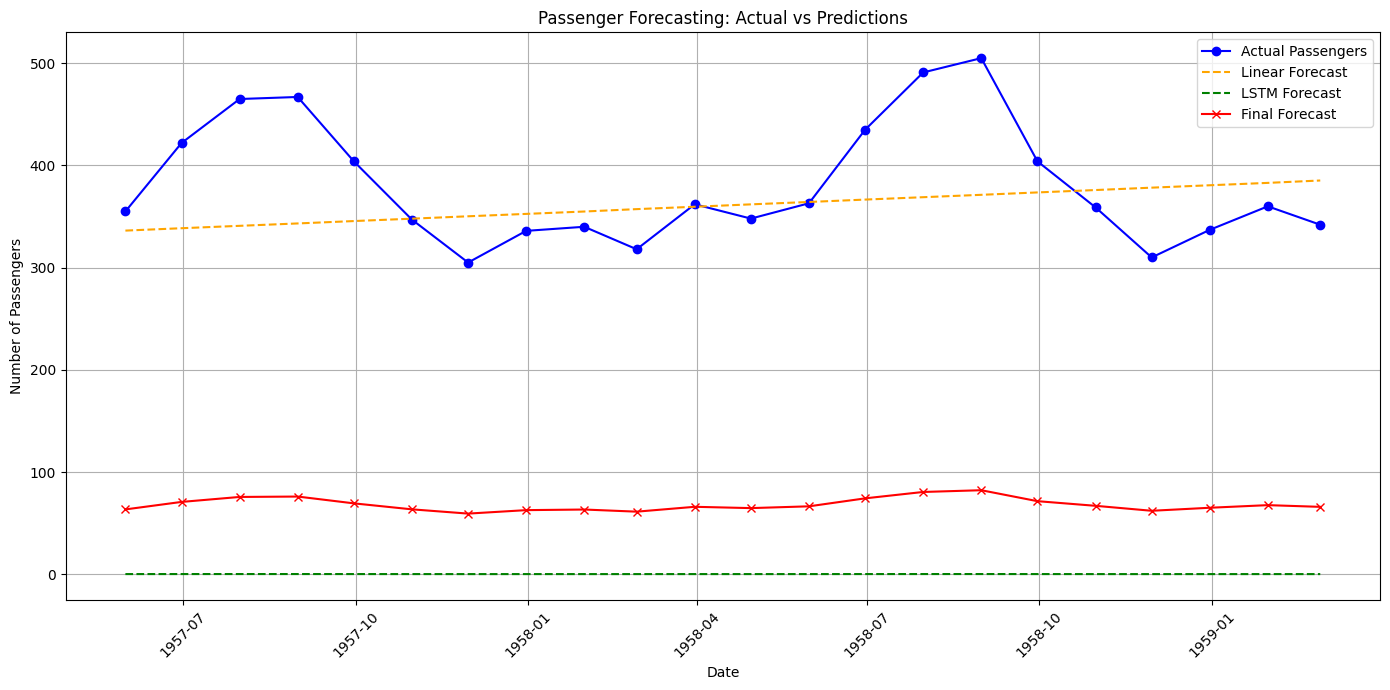

In [44]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Actual'], label='Actual Passengers', color='blue', marker='o')
plt.plot(results.index, results['Linear Forecast'], label='Linear Forecast', color='orange', linestyle='--')
plt.plot(results.index, results['LSTM Forecast'], label='LSTM Forecast', color='green', linestyle='--')
plt.plot(results.index, results['Final Forecast'], label='Final Forecast', color='red', marker='x')

# Adding labels and title
plt.title('Passenger Forecasting: Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show plot
plt.tight_layout()
plt.show()

***Q3) Use additive STL decomposition to decompose the time series using seasonal, trend
and residual components. Model the trend component using linear regression, seasonal
component using LSTM and residual component using GRU. Using this decomposition
based hybrid model forecast the number of passengers travelling in an airline. Use 70-
15-15 % ratios in train, validation and test sets.***

In [37]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Passengers.csv', parse_dates=['Month'])
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')  # Convert to datetime
data.set_index('Month', inplace=True)

# Decompose the time series using STL
stl = STL(data['#Passengers'], seasonal=13)
result = stl.fit()

# Extract components
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Prepare indices for splitting
X = np.arange(len(trend)).reshape(-1, 1)  # Time as feature (0, 1, 2, ...)

# Split data into train, validation, and test sets (70-15-15)
X_train, X_temp, trend_train, trend_temp = train_test_split(X, trend, test_size=0.30, shuffle=False)
X_val, X_test, trend_val, trend_test = train_test_split(X_temp, trend_temp, test_size=0.50, shuffle=False)

# Prepare seasonal and residual components for train and validation sets
seasonal_train = seasonal[:len(trend_train)].values
seasonal_val = seasonal[len(trend_train):len(trend_train)+len(trend_val)].values

residual_train = residual[:len(trend_train)].values
residual_val = residual[len(trend_train):len(trend_train)+len(trend_val)].values

# Model the Trend Component using Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, trend_train)
trend_forecast = linear_model.predict(X_val)

# Prepare the seasonal data for LSTM
seasonal_train_reshaped = seasonal_train.reshape((len(seasonal_train), 1, 1))
seasonal_val_reshaped = seasonal_val.reshape((len(seasonal_val), 1, 1))

# Model the Seasonal Component using LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM on seasonal component
lstm_model.fit(seasonal_train_reshaped, seasonal_train, epochs=50, verbose=0)

# Forecast using LSTM
seasonal_forecast = lstm_model.predict(seasonal_val_reshaped)

# Prepare the residual data for GRU
residual_train_reshaped = residual_train.reshape((len(residual_train), 1, 1))
residual_val_reshaped = residual_val.reshape((len(residual_val), 1, 1))

# Model the Residual Component using GRU
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(1, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train GRU on residual component
gru_model.fit(residual_train_reshaped, residual_train, epochs=50, verbose=0)

# Forecast using GRU
residual_forecast = gru_model.predict(residual_val_reshaped)

# Final forecast by combining trend, seasonal, and residual forecasts
final_forecast = trend_forecast + seasonal_forecast.flatten() + residual_forecast.flatten()

# Output the results
results = pd.DataFrame({
    'Actual': trend_val,
    'Trend Forecast': trend_forecast,
    'Seasonal Forecast': seasonal_forecast.flatten(),
    'Residual Forecast': residual_forecast.flatten(),
    'Final Forecast': final_forecast
}, index=trend_val.index)

# Print the results
print(results)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
                Actual  Trend Forecast  Seasonal Forecast  Residual Forecast  \
Month                                                                          
1957-05-01  363.125332      340.602726          -3.178432          -3.045079   
1957-06-01  366.147001      343.002220          46.046787           9.362309   
1957-07-01  368.744138      345.401714         100.582886          -1.813139   
1957-08-01  370.794915      347.801207          96.345673           2.510545   
1957-09-01  372.300611      350.200701          18.146402          10.971796   
1957-10-01  373.399147      352.600194         -26.858238           2.062059   
1957-11-01  374.258052      354.999688         -83.069199           5.978459   
1957-12-01  375.084200      357.399182         -45.834682           5.035767   
1958-01-01  375.946089      359.798675         -35.107327          -0.821910   
1958-02-01  376.822763      362.198169    

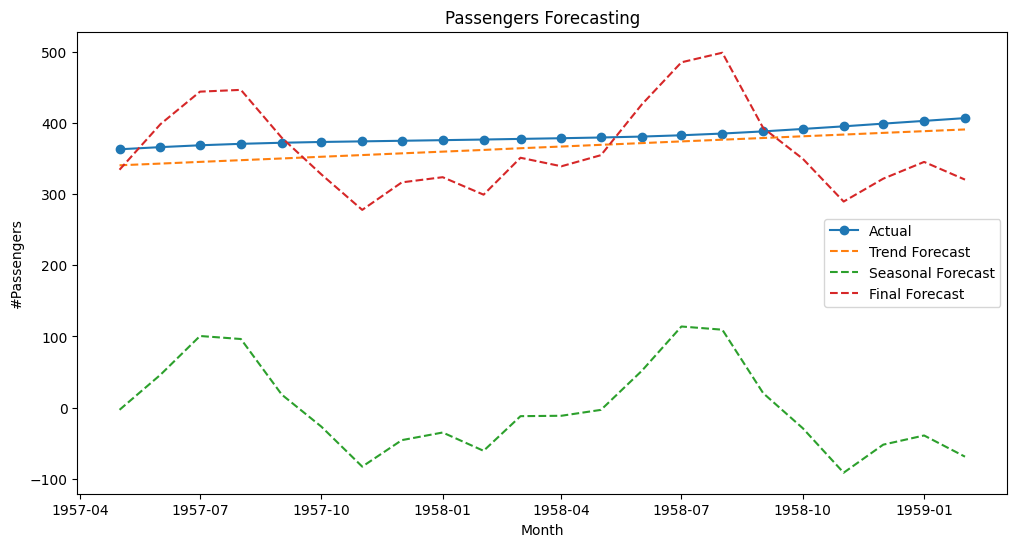

In [38]:
# Optional: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(trend_val.index, results['Actual'], label='Actual', marker='o')
plt.plot(trend_val.index, results['Trend Forecast'], label='Trend Forecast', linestyle='--')
plt.plot(trend_val.index, results['Seasonal Forecast'], label='Seasonal Forecast', linestyle='--')
plt.plot(trend_val.index, results['Final Forecast'], label='Final Forecast', linestyle='--')
plt.legend()
plt.title('Passengers Forecasting')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.show()

 ***Q4) Use multiplicative STL decomposition to decompose the time series using seasonal,
trend and residual components. Model the trend component using linear regression,
seasonal component using LSTM and residual component using GRU. Using this
decomposition based hybrid model forecast the number of passengers travelling in an
airline. Use 70-15-15 % ratios in train, validation and test sets.***

In [40]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Passengers.csv', parse_dates=['Month'])
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')  # Convert to datetime
data.set_index('Month', inplace=True)

# Decompose the time series using multiplicative STL
result = STL(data['#Passengers'], seasonal=13, robust=True).fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Prepare indices for splitting
trend = trend.dropna()
seasonal = seasonal.dropna()
residual = residual.dropna()

# Prepare time indices
X = np.arange(len(trend)).reshape(-1, 1)  # Time as feature (0, 1, 2, ...)

# Split data into train, validation, and test sets (70-15-15)
X_train, X_temp, trend_train, trend_temp = train_test_split(X, trend, test_size=0.30, shuffle=False)
X_val, X_test, trend_val, trend_test = train_test_split(X_temp, trend_temp, test_size=0.50, shuffle=False)

# Prepare seasonal and residual components for train and validation sets
seasonal_train = seasonal[:len(trend_train)].values
seasonal_val = seasonal[len(trend_train):len(trend_train) + len(trend_val)].values

residual_train = residual[:len(trend_train)].values
residual_val = residual[len(trend_train):len(trend_train) + len(trend_val)].values

# Model the Trend Component using Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, trend_train)
trend_forecast = linear_model.predict(X_val)

# Prepare the seasonal data for LSTM
seasonal_train_reshaped = seasonal_train.reshape((len(seasonal_train), 1, 1))
seasonal_val_reshaped = seasonal_val.reshape((len(seasonal_val), 1, 1))

# Model the Seasonal Component using LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM on seasonal component
lstm_model.fit(seasonal_train_reshaped, seasonal_train, epochs=50, verbose=0)

# Forecast using LSTM
seasonal_forecast = lstm_model.predict(seasonal_val_reshaped)

# Prepare the residual data for GRU
residual_train_reshaped = residual_train.reshape((len(residual_train), 1, 1))
residual_val_reshaped = residual_val.reshape((len(residual_val), 1, 1))

# Model the Residual Component using GRU
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(1, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train GRU on residual component
gru_model.fit(residual_train_reshaped, residual_train, epochs=50, verbose=0)

# Forecast using GRU
residual_forecast = gru_model.predict(residual_val_reshaped)

# Final forecast by combining trend, seasonal, and residual forecasts
final_forecast = trend_forecast * seasonal_forecast.flatten() * residual_forecast.flatten()

# Output the results
results = pd.DataFrame({
    'Actual': trend_val,
    'Trend Forecast': trend_forecast,
    'Seasonal Forecast': seasonal_forecast.flatten(),
    'Residual Forecast': residual_forecast.flatten(),
    'Final Forecast': final_forecast
}, index=trend_val.index)

# Print the results
print(results)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
                Actual  Trend Forecast  Seasonal Forecast  Residual Forecast  \
Month                                                                          
1957-05-01  361.439931      341.200261          -2.774401          -2.036687   
1957-06-01  364.321364      343.611853          41.931698          14.561177   
1957-07-01  367.007965      346.023445         100.871918           1.957950   
1957-08-01  369.512767      348.435037         101.483513           0.772088   
1957-09-01  371.818256      350.846629          14.487537          14.621032   
1957-10-01  373.862305      353.258221         -29.229685           3.406634   
1957-11-01  375.637211      355.669813         -82.210526           6.598112   
1957-12-01  377.286847      358.081405         -45.772106           3.336574   
1958-01-01  378.847536      360.492997         -37.343731          -2.015183   
1958-02-01  380.298756      362.904589    

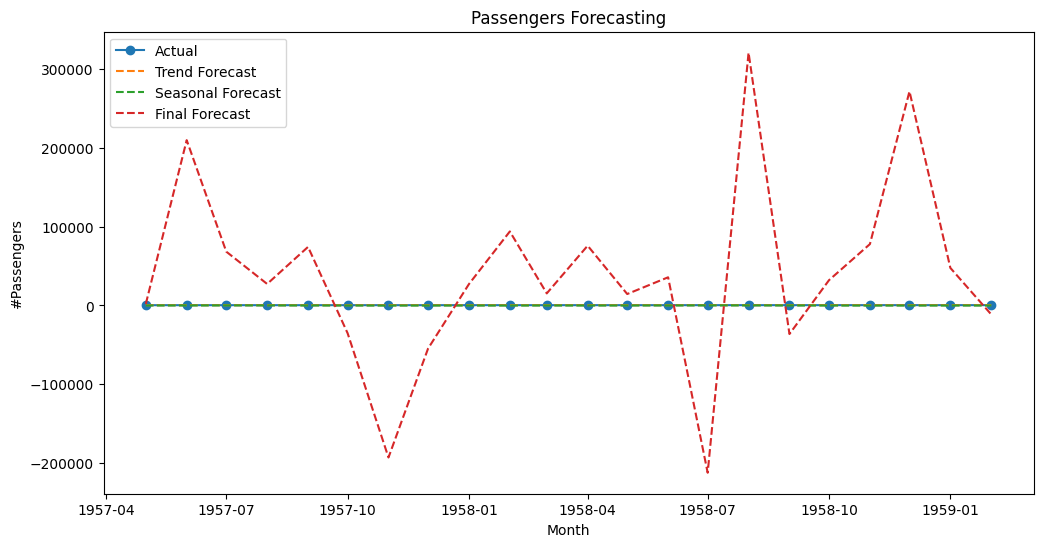

In [41]:
# Optional: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(trend_val.index, results['Actual'], label='Actual', marker='o')
plt.plot(trend_val.index, results['Trend Forecast'], label='Trend Forecast', linestyle='--')
plt.plot(trend_val.index, results['Seasonal Forecast'], label='Seasonal Forecast', linestyle='--')
plt.plot(trend_val.index, results['Final Forecast'], label='Final Forecast', linestyle='--')
plt.legend()
plt.title('Passengers Forecasting')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.show()